In [1]:
import gc
import time
from typing import List

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML, display

from sklearn.datasets import fetch_covtype
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import Tensor
from torch.optim import Optimizer
from torch.autograd import Function
import torch.utils.benchmark as benchmark
import torch._dynamo
import torch._inductor.metrics as metrics

from torchinfo import summary

In [2]:
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')
DEVICE = device

In [3]:
df = sns.load_dataset('diamonds')
df = df[['carat', 'depth', 'table', 'price', 'x', 'y', 'z', 'cut']]

df['cut'] = (df['cut'] == 'Ideal').astype(int)

X = df.drop('cut', axis=1)
y = df['cut']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

print(X.shape)
print(y.shape)

ideal_percentage = df['cut'].mean() * 100
print(f"Percentage of diamonds with 'Ideal' cut: {ideal_percentage:.2f}%")

model = LogisticRegression(penalty='l2', C=0.001, max_iter=10000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_pred_proba = model.predict_proba(X_test)
loss = log_loss(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Ideal', 'Ideal']))

print(model.coef_)
print(f"Log Loss: {loss:.6f}")

(53940, 7)
(53940,)
Percentage of diamonds with 'Ideal' cut: 39.95%
Test Accuracy: 79.30%
Classification Report:
              precision    recall  f1-score   support

   Not Ideal       0.82      0.85      0.83      6496
       Ideal       0.75      0.71      0.73      4292

    accuracy                           0.79     10788
   macro avg       0.79      0.78      0.78     10788
weighted avg       0.79      0.79      0.79     10788

[[-0.15688782 -0.46189194 -1.57368125  0.22509094 -0.08309788 -0.03167662
  -0.08671039]]
Log Loss: 0.451068


/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: divide by zero encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: overflow encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning: invalid value encountered in matmul
  raw_prediction = X @ weights + intercept
/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/nhatt/Downloads/All_Mac/Code/ML_experiments/.venv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered

In [85]:
def train(
    model,
    criterion,
    optimizers: List[torch.optim.Optimizer],
    epochs: int,
    *,
    plot_every: int = 50,
    anim_interval_ms: int = 500,
    warmup_epochs = 100
): 
    print(summary(model, input_data=X_train_tensor))

    plt.rcParams['animation.embed_limit'] = 50

    torch.set_printoptions(threshold=float("inf"))

    best_test_loss = float("inf")
    train_losses: list[float] = []
    test_losses: list[float] = []
    learning_rates: list[float] = []

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.reset_peak_memory_stats()
        torch.cuda.synchronize()

    schedulers = [
        torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, factor=0.99999, patience=0, threshold=0, eps=0
        )
        for opt in optimizers
    ]

    frames: list[np.ndarray] = []

    for epoch in range(1, epochs + 1):
        if epoch <= warmup_epochs:
            warmup_scale = epoch / warmup_epochs
            for opt in optimizers:
                for group in opt.param_groups:
                    group["lr"] = group.get("base_lr", group["lr"]) * warmup_scale

        model.train()
        for opt in optimizers:
            opt.zero_grad()

        train_outputs = model(X_train_tensor)

        train_loss = criterion(train_outputs, y_train_tensor)
        train_loss.backward()
        
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test_tensor)
            test_loss = criterion(test_outputs, y_test_tensor)
            test_predictions = torch.argmax(test_outputs, dim=1)
            test_accuracy = (
                (test_predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)
            )

        for opt in optimizers:
            opt.step()

        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        learning_rates.append(schedulers[0].optimizer.param_groups[0]["lr"])

        if test_loss.item() < best_test_loss:
            best_test_loss = test_loss.item()

        if epoch > warmup_epochs:
            for sched in schedulers:
                sched.step(train_loss.item())

        if epoch % 50 == 0:
            print(
                f"Epoch {epoch}/{epochs}, "
                f"Train Loss: {train_loss.item():.6f}, "
                f"Test Loss: {test_loss.item():.6f}, "
                f"Test Acc: {test_accuracy:.4f}, "
                f"LR: {schedulers[0].optimizer.param_groups[0]['lr']:.4e}"
            )
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
        print(
            f"[GPU] Peak memory allocated: "
            f"{torch.cuda.max_memory_allocated() / 1024 ** 2:.2f} MB"
        )
        print(
            f"[GPU] Peak memory reserved: "
            f"{torch.cuda.max_memory_reserved() / 1024 ** 2:.2f} MB"
        )

    print()
    print(f"Lowest Test Loss: {best_test_loss:.8f}")

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [86]:
class MADBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=False, track_running_stats=True):
        super(MADBatchNorm1d, self).__init__()
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.track_running_stats = track_running_stats

        if self.track_running_stats:
            self.register_buffer('running_mean', torch.zeros(num_features))
            self.register_buffer('running_mad', torch.ones(num_features))
            self.running_mean: torch.Tensor
            self.running_mad: torch.Tensor
            self.register_buffer('num_batches_tracked', torch.tensor(0, dtype=torch.long))

    def forward(self, x):
        if x.dim() != 2:
            raise ValueError("Input must be 2D (batch, features)")

        if self.training or not self.track_running_stats:
            mean = x.mean(dim=0)
            mad = (x - mean).abs().mean(dim=0)

            if self.track_running_stats:
                with torch.no_grad():
                    self.running_mean.mul_(1 - self.momentum).add_(self.momentum * mean)
                    self.running_mad.mul_(1 - self.momentum).add_(self.momentum * mad)
                    self.num_batches_tracked += 1
            normed = (x - mean) / (mad + self.eps)

        else:
            normed = (x - self.running_mean) / (self.running_mad + self.eps)

        return normed

In [ ]:
class KANLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, init: str, num_control_points: int):
        super(KANLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_control_points = num_control_points

        self.r_weight = nn.Parameter(torch.zeros(in_features, num_control_points, out_features)) # (in_features, num_control_points, out_features)
        self.l_weight = nn.Parameter(torch.zeros(in_features, num_control_points, out_features)) # (in_features, num_control_points, out_features)

        self.register_buffer("local_bias", torch.arange(num_control_points).view(1, num_control_points, 1)) # (1, num_control_points, 1)
        self.register_buffer("feature_offset", torch.arange(in_features).view(1, -1) * self.num_control_points) # (1, in_features)

        if init == 'random_normal':
            random_data = torch.randn((in_features, out_features), device=self.r_weight.device)
            norms = torch.norm(random_data, p=2, dim=0, keepdim=True)

            with torch.no_grad():
                self.r_weight.data[:, 0, :] = random_data / norms
        elif init == 'identity':
            if in_features != out_features:
                raise ValueError(f"For 'identity' init, in_features ({in_features}) and out_features ({out_features}) must be the same.")

            with torch.no_grad():
                self.r_weight.data[:, 0, :] = torch.eye(in_features, device=self.r_weight.device)
        elif init != 'none':
            raise ValueError("Initialization method must be 'random_normal', 'identity', or 'none'.")

    def forward(self, x):
        # x: (batch_size, in_features)
        
        lower_indices_float = x.floor().clamp(0, self.num_control_points - 2) # (batch_size, in_features)
        lower_indices = lower_indices_float.long() + self.feature_offset # (batch_size, in_features)

        indices = torch.stack((lower_indices, lower_indices + 1), dim=-1) # (batch_size, in_features, 2)
        vals = F.embedding(indices, self.get_interp_tensor()) # (batch_size, in_features, 2, out_features)

        lower_val, upper_val = vals.unbind(dim=2) # each: (batch_size, in_features, out_features)
        return torch.lerp(lower_val, upper_val, (x - lower_indices_float).unsqueeze(-1)).sum(dim=1) # (batch_size, out_features)

    def get_interp_tensor(self):
        cs_r_weight = torch.cumsum(self.r_weight, dim=1) # (in_features, num_control_points, out_features)
        cs_l_weight = torch.cumsum(self.l_weight, dim=1) # (in_features, num_control_points, out_features)

        cs_r_weight_bias_prod = torch.cumsum(self.r_weight * self.local_bias, dim=1) # type: ignore (in_features, num_control_points, out_features)
        cs_l_weight_bias_prod = torch.cumsum(self.l_weight * self.local_bias, dim=1) # type: ignore (in_features, num_control_points, out_features)

        r_interp = (self.local_bias * cs_r_weight - cs_r_weight_bias_prod) # type: ignore (in_features, num_control_points, out_features)
        l_interp = (cs_l_weight_bias_prod[:, -1:, :] - cs_l_weight_bias_prod) - self.local_bias * (cs_l_weight[:, -1:, :] - cs_l_weight) # type: ignore (in_features, num_control_points, out_features)
        return (r_interp + l_interp).view(-1, self.out_features) # (in_features * num_control_points, out_features)

    def visualize_all_mappings(self):
        interp_tensor = self.get_interp_tensor().detach().cpu()
        interp_tensor = interp_tensor.view(self.in_features, self.num_control_points, self.out_features)

        fig, axes = plt.subplots(self.in_features, self.out_features, figsize=(4 * self.out_features, 3 * self.in_features))

        for i in range(self.in_features):
            for j in range(self.out_features):
                ax = axes[i, j] if self.in_features > 1 and self.out_features > 1 else axes[max(i, j)]
                ax.plot(interp_tensor[i, :, j])
                ax.set_title(f'In {i} → Out {j}')
                ax.set_xlabel('Control Points')
                ax.set_ylabel('Value')
                ax.grid(True)
        
        plt.tight_layout()
        plt.show()

In [ ]:
class StableNN(nn.Module):
    def __init__(self, in_features: int, mid_features: int, out_features: int, num_control_points: int, spline_range: int):
        super().__init__()
        self.num_control_points = num_control_points
        self.spline_range = spline_range

        self.mad_bn1 = MADBatchNorm1d(in_features, momentum=1.0, affine=False, track_running_stats=True)
        self.kan_layer1 = KANLayer(in_features=in_features, out_features=mid_features, num_control_points=num_control_points, init='random_normal')

        self.mad_bn2 = MADBatchNorm1d(mid_features, momentum=1.0, affine=False, track_running_stats=True)
        self.kan_layer2 = KANLayer(in_features=mid_features, out_features=mid_features, num_control_points=num_control_points, init='random_normal')

        self.mad_bn3 = MADBatchNorm1d(mid_features, momentum=1.0, affine=False, track_running_stats=True)
        self.kan_layer3 = KANLayer(in_features=mid_features, out_features=out_features, num_control_points=num_control_points, init='random_normal')

    def forward(self, x):
        x = self.mad_bn1(x)
        x = (x + self.spline_range) * (self.num_control_points - 1) / (2 * self.spline_range)
        x = self.kan_layer1(x)

        x = self.mad_bn2(x)
        x = (x + self.spline_range) * (self.num_control_points - 1) / (2 * self.spline_range)
        x = self.kan_layer2(x)

        x = self.mad_bn3(x)
        x = (x + self.spline_range) * (self.num_control_points - 1) / (2 * self.spline_range)
        x = self.kan_layer3(x)
        return x

In [ ]:
model = torch.compile(StableNN(in_features=X.shape[1], mid_features=8, out_features=X.shape[1], num_control_points=16, spline_range=8), backend="aot_eager").to(device)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.AdamW(model.parameters(), lr=0.001 * 2, weight_decay=0.0)]

for opt in optimizers:
    for g in opt.param_groups:
        g.setdefault("base_lr", g["lr"])

In [126]:
train(model, criterion, optimizers, epochs=10000, warmup_epochs=1000, plot_every=50) # type: ignore

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 7]                --
├─StableNN: 1-1                          [43152, 7]                --
│    └─MADBatchNorm1d: 2-1               [43152, 7]                --
│    └─KANLayer: 2-2                     [43152, 8]                3,584
│    └─MADBatchNorm1d: 2-3               [43152, 8]                --
│    └─KANLayer: 2-4                     [43152, 8]                4,096
│    └─MADBatchNorm1d: 2-5               [43152, 8]                --
│    └─KANLayer: 2-6                     [43152, 7]                3,584
Total params: 11,264
Trainable params: 11,264
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 3.73
Input size (MB): 1.21
Forward/backward pass size (MB): 7.94
Params size (MB): 0.05
Estimated Total Size (MB): 9.19
Epoch 50/10000, Train Loss: 8.120864, Test Loss: 8.078494, Test Acc: 0.6021, LR: 1.0000e-04


KeyboardInterrupt: 

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 7]                --
├─StableNN: 1-1                          [43152, 7]                3,520
Total params: 3,520
Trainable params: 3,520
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21
Epoch 50/10000, Train Loss: 1.479346, Test Loss: 1.469480, Test Acc: 0.5934, LR: 1.0000e-04
Epoch 100/10000, Train Loss: 0.613900, Test Loss: 0.611209, Test Acc: 0.6582, LR: 2.0000e-04
Epoch 150/10000, Train Loss: 0.469054, Test Loss: 0.468243, Test Acc: 0.8028, LR: 3.0000e-04
Epoch 200/10000, Train Loss: 0.413452, Test Loss: 0.413252, Test Acc: 0.8408, LR: 4.0000e-04
Epoch 250/10000, Train Loss: 0.371493, Test Loss: 0.373421, Test Acc: 0.8585, LR: 5.0000e-04
Epoch 300/10000, Train Loss: 0.343046, Test Loss: 0.346618, Test Acc: 0.8696, LR: 6.0000e-04
Epoch

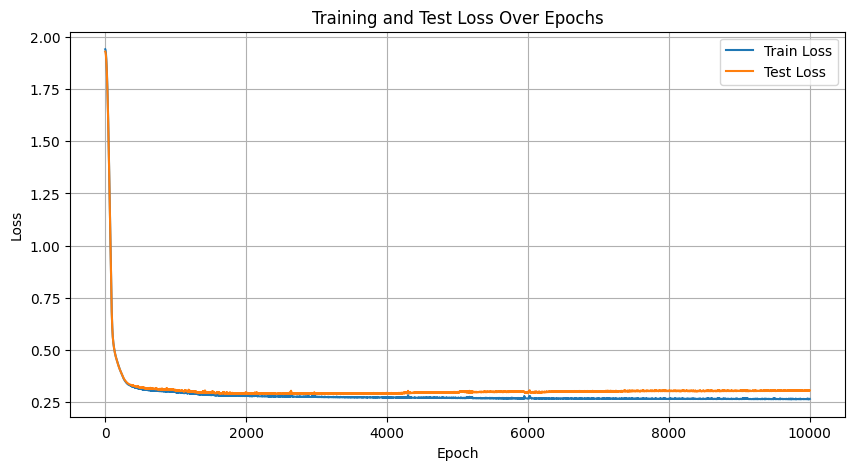

In [93]:
train(model, criterion, optimizers, epochs=10000, warmup_epochs=1000, plot_every=50) # type: ignore

In [115]:
class StableNN(nn.Module):
    def __init__(self, in_features: int, mid_features: int, out_features: int):
        super().__init__()
        self.mad_bn1 = MADBatchNorm1d(in_features, momentum=1.0, affine=False, track_running_stats=True)
        self.linear1 = nn.Linear(in_features, mid_features)

        self.mad_bn2 = MADBatchNorm1d(mid_features, momentum=1.0, affine=False, track_running_stats=True)
        self.linear2 = nn.Linear(mid_features, mid_features)

        self.mad_bn3 = MADBatchNorm1d(mid_features, momentum=1.0, affine=False, track_running_stats=True)
        self.linear3 = nn.Linear(mid_features, out_features)

        with torch.no_grad():
            l1_norm = torch.norm(self.linear1.weight)
            self.linear1.weight.div_(l1_norm)

            nn.init.eye_(self.linear2.weight)
            nn.init.zeros_(self.linear2.bias)

            nn.init.zeros_(self.linear3.weight)
            nn.init.zeros_(self.linear3.bias)


    def forward(self, x):
        x = self.mad_bn1(x)
        x = self.linear1(x)
        x = F.relu(x)

        x = self.mad_bn2(x)
        x = self.linear2(x)
        x = F.relu(x)

        x = self.mad_bn3(x)
        x = self.linear3(x)
        return x

In [120]:
model = torch.compile(StableNN(in_features=X.shape[1], mid_features=64, out_features=X.shape[1]), backend="aot_eager").to(device)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.AdamW(model.parameters(), lr=0.001 * 0.5, weight_decay=0.0)]

for opt in optimizers:
    for g in opt.param_groups:
        g.setdefault("base_lr", g["lr"])

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 7]                --
├─StableNN: 1-1                          [43152, 7]                5,127
Total params: 5,127
Trainable params: 5,127
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21
Epoch 50/10000, Train Loss: 1.933905, Test Loss: 1.933746, Test Acc: 0.6709, LR: 2.5000e-05
Epoch 100/10000, Train Loss: 1.885670, Test Loss: 1.885303, Test Acc: 0.7109, LR: 5.0000e-05
Epoch 150/10000, Train Loss: 1.780543, Test Loss: 1.779678, Test Acc: 0.7357, LR: 7.5000e-05
Epoch 200/10000, Train Loss: 1.609389, Test Loss: 1.610469, Test Acc: 0.7686, LR: 1.0000e-04
Epoch 250/10000, Train Loss: 1.402448, Test Loss: 1.404622, Test Acc: 0.7900, LR: 1.2500e-04
Epoch 300/10000, Train Loss: 1.209893, Test Loss: 1.212042, Test Acc: 0.8042, LR: 1.5000e-04
Epoch

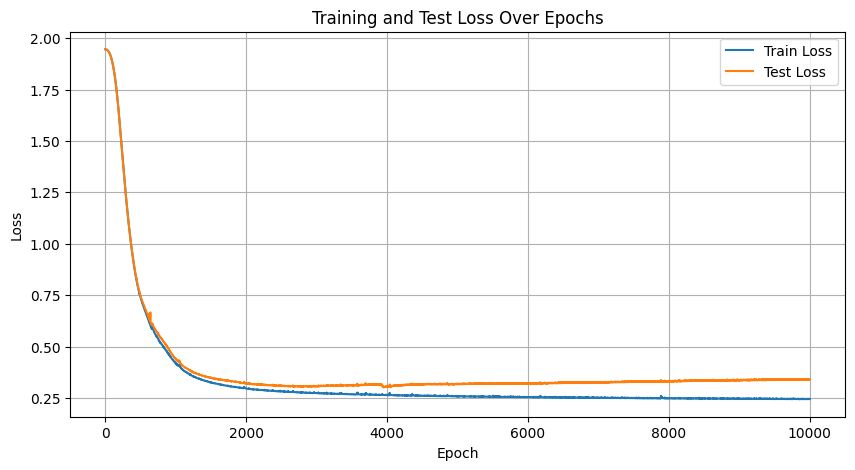

In [121]:
train(model, criterion, optimizers, epochs=10000, warmup_epochs=1000, plot_every=50) # type: ignore

In [118]:
model = torch.compile(StableNN(in_features=X.shape[1], mid_features=64, out_features=X.shape[1]), backend="aot_eager").to(device)
criterion = nn.CrossEntropyLoss()
optimizers = [optim.AdamW(model.parameters(), lr=0.001 * 1, weight_decay=0.0)]

for opt in optimizers:
    for g in opt.param_groups:
        g.setdefault("base_lr", g["lr"])

Layer (type:depth-idx)                   Output Shape              Param #
OptimizedModule                          [43152, 7]                --
├─StableNN: 1-1                          [43152, 7]                5,127
Total params: 5,127
Trainable params: 5,127
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 1.21
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 1.21
Epoch 50/10000, Train Loss: 1.923630, Test Loss: 1.922920, Test Acc: 0.6861, LR: 5.0000e-05
Epoch 100/10000, Train Loss: 1.816922, Test Loss: 1.814981, Test Acc: 0.7428, LR: 1.0000e-04
Epoch 150/10000, Train Loss: 1.564216, Test Loss: 1.564830, Test Acc: 0.7855, LR: 1.5000e-04
Epoch 200/10000, Train Loss: 1.254724, Test Loss: 1.258480, Test Acc: 0.8033, LR: 2.0000e-04
Epoch 250/10000, Train Loss: 1.011379, Test Loss: 1.017267, Test Acc: 0.8404, LR: 2.5000e-04
Epoch 300/10000, Train Loss: 0.849447, Test Loss: 0.856113, Test Acc: 0.8725, LR: 3.0000e-04
Epoch

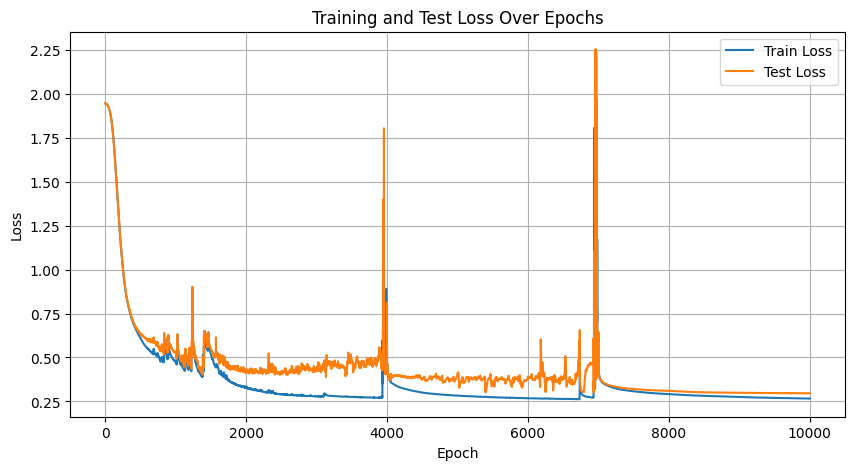

In [119]:
train(model, criterion, optimizers, epochs=10000, warmup_epochs=1000, plot_every=50) # type: ignore